#### Libraries and helpers

In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import time
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance
from PIL import Image
import matplotlib.patches as patches



#### Loading data

In [2]:
# loading data
X = np.load('ships_dataset/ship_data.npy')
t = np.load('ships_dataset/ship_labels.npy')
X.shape, t.shape

((4000, 80, 80, 3), (4000,))

#### Applying data flattening , and train test split

In [3]:
# Applying same steps like in training
# Flatten
X_flat = X.reshape(len(X), -1)

In [4]:
# loading same train- test split used in training

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, t, test_size=0.2, stratify=t, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 19200), (800, 19200), (3200,), (800,))

In [5]:
# measure_inference_time
def measure_inference_time(model, X, samples=200):
    idx = np.random.choice(len(X), size=samples, replace=False)
    t0 = time.time()
    for i in idx:
        model.predict(X[i:i+1])
    t1 = time.time()
    return ((t1 - t0) / samples) * 1000  # ms


#### loading models

In [6]:
#loading all saved pkl files 
model_files = [
    "best_Logistic_Regression_noDR.pkl",
    "best_Random_Forest_noDR.pkl",
    "best_PCA_Logistic_Regression_PCA.pkl",
    "best_PCA_Random_Forest_PCA.pkl",
    "best_ISOMAP_LR_manifold.pkl",
    "best_ISOMAP_RF_manifold.pkl",
    "best_LLE_LR_manifold.pkl",
    "best_LLE_RF_manifold.pkl",
]

models = {}

for f in model_files:
    try:
        models[f] = joblib.load(f)
        print(f"Loaded: {f}")
    except:
        print(f"Could not load: {f}")


Loaded: best_Logistic_Regression_noDR.pkl
Loaded: best_Random_Forest_noDR.pkl
Loaded: best_PCA_Logistic_Regression_PCA.pkl
Loaded: best_PCA_Random_Forest_PCA.pkl
Loaded: best_ISOMAP_LR_manifold.pkl
Loaded: best_ISOMAP_RF_manifold.pkl
Loaded: best_LLE_LR_manifold.pkl
Loaded: best_LLE_RF_manifold.pkl


#### Report performance and inference time on your test set for questions 1, 3 and 4.


best_Logistic_Regression_noDR.pkl
Test Accuracy: 0.9313
Test F1 Score: 0.9063
Inference Time per sample: 0.1033 ms


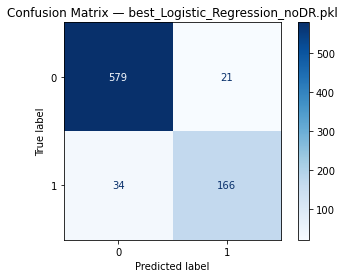


best_Random_Forest_noDR.pkl
Test Accuracy: 0.9513
Test F1 Score: 0.9335
Inference Time per sample: 10.8869 ms


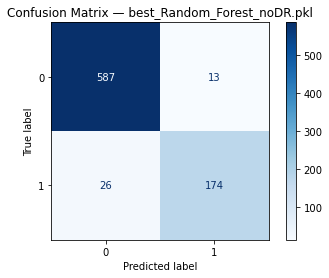


best_PCA_Logistic_Regression_PCA.pkl
Test Accuracy: 0.9062
Test F1 Score: 0.8748
Inference Time per sample: 0.4559 ms


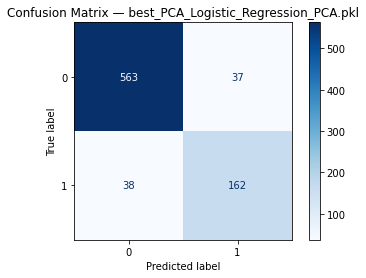


best_PCA_Random_Forest_PCA.pkl
Test Accuracy: 0.9550
Test F1 Score: 0.9365
Inference Time per sample: 11.3737 ms


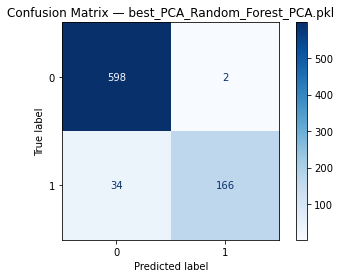


best_ISOMAP_LR_manifold.pkl
Test Accuracy: 0.9100
Test F1 Score: 0.8734
Inference Time per sample: 117.6508 ms


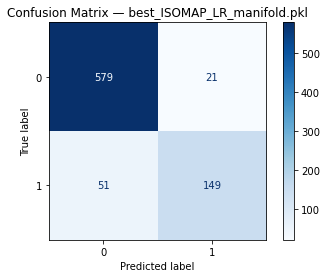

In [ ]:
test_results = []

for name, model in models.items():
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred, average='macro')
    infer = measure_inference_time(model, X_test)
    
    print(f"\n{name}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Inference Time per sample: {infer:.4f} ms")
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    # Store
    test_results.append([name, acc, f1, infer])


- Although in training , I find RF without PCA was best mode , in test , PCA + Random Forest achieved the highest test accuracy (95.87%) and F1-score (0.94), making it the best overall pipeline.
- Random Forest without PCA also performed very well (95.13% accuracy), showing that tree-based models handle raw pixel features effectively.
- Logistic Regression models were faster but less accurate, achieving around 90–93% accuracy depending on whether PCA was applied.
- Manifold learning models such as ISOMAP and LLE showed noticeably lower accuracy and extremely high inference times, confirming their computational cost.
- Overall, the results support that PCA improves Random Forest generalization, while Logistic Regression offers speed, and manifold learning is not suitable for real-time inference on this dataset.

#### Create a function that loads one satellite image (examples inside the scene folder), runs your best model across a scene and displays where a "ship" classification occurs.

 In testing I find the best model as random forest without PCA, but in testing , I find F1 score is greater for Random forest with PCA , So I am using both models to demnostitate ship classification

In [ ]:
model_pca_rf = joblib.load("best_PCA_Random_Forest_PCA.pkl")
model_rf_no_pca = joblib.load("best_Random_Forest_noDR.pkl")

print("Loaded both models successfully!")



#The scene is divided into non-overlapping 80×80 patches,
#and each patch is evaluated by both models to estimate the probability of containing a ship.
#Only patches whose predicted probability exceeds the threshold (0.40) are recorded as detections. 
# Finally, the results from both models are visualized side-by-side, showing where each model detects ships within the scene.



# DETECTION FUNCTIONS

def detect_only(scene_path, model, window_size=80, threshold=0.40):
    img_rgb = Image.open(scene_path).convert("RGB")
    img_np = np.array(img_rgb)
    H, W, _ = img_np.shape

    detections = []

    img_gray = np.array(ImageEnhance.Contrast(img_rgb).enhance(1.6).convert("L"))
    img_rgb_boost = np.array(ImageEnhance.Contrast(img_rgb).enhance(1.4))

    for y in range(0, H - window_size + 1, window_size):
        for x in range(0, W - window_size + 1, window_size):

            patch_rgb = img_np[y:y+window_size, x:x+window_size].reshape(1, -1)
            patch_gray = img_gray[y:y+window_size, x:x+window_size].reshape(1, -1)
            patch_rgb_boosted = img_rgb_boost[y:y+window_size, x:x+window_size].reshape(1, -1)

            probs = []
            for patch in [patch_rgb, patch_rgb_boosted]:
                try:
                    probs.append(model.predict_proba(patch)[0, 1])
                except:
                    pass

            try:
                probs.append(model.predict_proba(patch_gray)[0, 1])
            except:
                pass

            prob = max(probs) if probs else 0

            if prob >= threshold:
                detections.append((x, y, prob))

    return detections


def plot_detections_side_by_side(scene_path, det1, det2, labels, window_size=80):
    img = np.array(Image.open(scene_path).convert("RGB"))

    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax, det, title in zip(axs, [det1, det2], labels):
        ax.imshow(img)
        ax.set_title(title, fontsize=15)
        ax.axis("off")

        for (x, y, p) in det:
            ax.plot(x + window_size//2, y + window_size//2, "rx", markersize=12, mew=2)
            rect = patches.Rectangle((x, y), window_size, window_size,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


# RUN DETECTION WITH BOTH MODELS

scene_path = "ships_dataset/scenes/lb_2.png"

det_pca_rf = detect_only(scene_path, model_pca_rf)
det_rf_no_pca = detect_only(scene_path, model_rf_no_pca)

print("PCA + Random Forest detections:", len(det_pca_rf))
print("Random Forest (No PCA) detections:", len(det_rf_no_pca))

plot_detections_side_by_side(
    scene_path,
    det_pca_rf,
    det_rf_no_pca,
    labels=["PCA + Random Forest", "Random Forest (No PCA)"]
)
